In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pickle
import os
import json
from itertools import product
import multiprocessing as mp
from math import isclose
from collections import defaultdict
from scipy.stats import kendalltau
from pathlib import Path

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

In [2]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

accuracy_matrix = np.load(os.path.join(data_path, 'acc_matrix_res64_all.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_matrix_full.npy'))
error_matrix = 1 - accuracy_matrix

idx_dataset_to_remove = 28 # remove full CIFAR100
memory_matrix = np.delete(memory_matrix, idx_dataset_to_remove, axis=0)
error_matrix = np.delete(error_matrix, idx_dataset_to_remove, axis=0)

In [3]:
n_datasets = error_matrix.shape[0]

In [4]:
def get_kendalltau_single_pair(idx_i, idx_j):
    dataset_i_errors = error_matrix[idx_i]
    dataset_j_errors = error_matrix[idx_j]
    return kendalltau(dataset_i_errors, dataset_j_errors)[0]

In [5]:
p1 = mp.Pool(100)
results = [p1.apply_async(get_kendalltau_single_pair, args=[idx_i, idx_j]) 
          for idx_i, idx_j in list(product(np.arange(n_datasets), np.arange(n_datasets)))]
p1.close()
p1.join()

In [6]:
kendalltau_on_datasets = np.full((n_datasets, n_datasets), np.nan)

count = 0
for idx_i in range(n_datasets):
    for idx_j in range(n_datasets):
        kendalltau_on_datasets[idx_i, idx_j] = results[count].get()
        count += 1

In [7]:
def CurlyBrace(ll_corner=(0, 0), width=1, height=1):
    import matplotlib.path as mpath
    import matplotlib.patches as mpatches
    import numpy as np
    Path = mpath.Path
    verts = np.array([(0, 0), (.5, 0), (.5, .2), (.5, .3), (.5, .5), (1, .5), (.5, .5), (.5, .7), (.5, .8), (.5, 1), (0, 1)])
    verts[:, 0] *= width
    verts[:, 1] *= height
    verts[:, 0] += ll_corner[0]
    verts[:, 1] += ll_corner[1]

    cb_patch = mpatches.PathPatch(
        Path(verts,
             [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3]),
        fc="none", clip_on=False, transform=ax.transData)
    return cb_patch

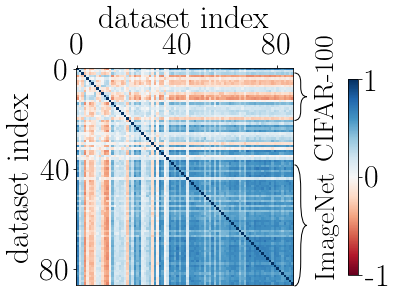

In [8]:
fontsize = 32
ax = plt.gca()

cmap = matplotlib.cm.get_cmap('RdBu')
cmap.set_bad(color='white')
im = ax.imshow(kendalltau_on_datasets, cmap=cmap, vmin=-1, vmax=1)
cax = ax.inset_axes([1.25, 0.05, 0.05, 0.9], transform=ax.transAxes)
cbar = ax.figure.colorbar(im, ax=ax, ticks=[-1, 0, 1], orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=fontsize) 
cbar.ax.tick_params(labelsize=fontsize) 
cbar.ax.set_yticklabels([-1, 0, 1], fontsize=fontsize)
# cmap.set_bad(color='red')
ax.set_xlabel('dataset index', fontsize=fontsize)
ax.set_ylabel('dataset index', fontsize=fontsize)

ax.set_xticks([0, 40, 80])
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels([0, 40, 80], fontsize=fontsize)
ax.set_yticks([0, 40, 80])
ax.set_yticklabels([0, 40, 80], fontsize=fontsize)
# plt.title("Absolute Kendall Tau")

bands = np.array([1, 37])
diff = np.array([20, 51])
bnames = ['CIFAR-100', 'ImageNet']
for y, h, bn in zip(bands, diff, bnames):
    cb = CurlyBrace([87, y+h*0.025], 5, h*0.95)
    ax.add_patch(cb)
    ax.text(95, y+h/2, bn, va='center', fontsize=fontsize-4, rotation=90)